In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
import os, random, collections
# import pandas as pd
import cv2
import numpy as np
import pandas as pd

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms

In [4]:
import sys
sys.path.append('/root/inplace_abn/')
sys.path.append('..')


from zoo.unet import DPNUnet
from utils.dataset import ISIC_Dataset, MEAN, STD

from utils.losses import BCEDiceLoss, DiceLoss, LossBinary
from utils.metrics import calc_iou
from utils.hard_negative import HardNegativeMiner

from utils.augmentations import Augmentation
%load_ext autoreload
%autoreload 2

In [5]:
# GPU_IDX = 1
LR_GAMMA = .9
SEED = 42
EPOCHS_NB = 50
PATHS = {
    'DATA': '../data/ISIC2018_Task1-2_Training_Input/',
}

In [6]:
def infer_on_dataset(model, dataset, idx, verbose=False, suffix=''):
    data = dataset[idx]
    pred_mask = F.sigmoid(model.forward(Variable(data['images'].unsqueeze(0)).cuda())[0]).data.cpu().numpy()
    
    image = (data['images'].numpy().T * STD + MEAN)[..., ::-1]
    true_mask = data['masks'].numpy().T
    pred_mask = pred_mask.T
    
    if verbose:
        _, ax = plt.subplots(ncols=3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[1].imshow(true_mask[..., 0])
        ax[2].imshow(pred_mask[..., 0])
    np.save('pics/image_{}'.format(suffix), image)
    np.save('pics/pred_mask_{}'.format(suffix), pred_mask)
    np.save('pics/true_mask_{}'.format(suffix), true_mask)

In [7]:
torch.cuda.set_device(0)

In [8]:
def unfreeze(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True

def unfreeze_bn(model):
    if isinstance(model, nn.BatchNorm2d):
        for param in model.parameters():
            param.requires_grad = True

    model = list(model.children())
    if len(model):
        for child in model:
            unfreeze_bn(child)
    return None


def freeze(model, end_block=-1):
    dpn = list(model.children())
    for l, child in enumerate(dpn[0].encoder_stages.children()):
        for param in child.parameters():
            param.requires_grad = l > end_block

    return model

In [10]:
def get_datasets(data_dir, fold, prefix='_shrinked', aug_strength=1.):
    train_dataset = ISIC_Dataset(data_dir, prefix=prefix, seed=SEED,
                                 augmentations=Augmentation(side=512, strength=aug_strength), part=fold, partsamount=4, exclude=True)
    val_dataset = ISIC_Dataset(data_dir, prefix=prefix, seed=SEED,
                               augmentations=Augmentation(side=576), is_test=True, part=fold, partsamount=4, exclude=False)
    return train_dataset, val_dataset


def get_datagens(train_dataset, val_dataset, train_batch_size=28):
    train_datagen = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size,
                                                shuffle=True, num_workers=8)
    val_datagen = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                              shuffle=False, num_workers=0)
    return train_datagen, val_datagen


def get_model(checkpoint=None, map_location=None, devices=None):
    model = DPNUnet(1, 3, encoder_name='dpn68')
    model.cuda();

    if checkpoint is not None:
        cbs = torch.load(checkpoint, map_location)
        model.load_state_dict(cbs.state_dict())

    if devices is not None:
        model = torch.nn.DataParallel(model, device_ids=devices)

    return model

In [11]:
def make_step(model, data, loss, opt=None, training=True):
    data['images'] = Variable(data['images']).cuda()
    data['masks'] = Variable(data['masks'] > 120).cuda().float()

    predictions = model(data['images'])
    l = loss(predictions, data['masks'])
    pred = F.sigmoid(predictions).data.cpu().numpy()
    iou = calc_iou(pred > 0.5, data['masks'].data.cpu().numpy())

    if training:
        l.backward()
        opt.step()

    return {
        'loss': l, 
        'iou': iou
    }

In [12]:
def train_on_epoch(model, loss, opt, datagen, epsilon=1e-5, hard_negative_miner=None):
    model.train()
    meters = list()

    for data in tqdm(datagen):
        opt.zero_grad()
        meters.append(make_step(model, data, loss, opt, training=True))

        if hard_negative_miner is not None:
            hard_negative_miner.update_cache(meters[-1], data)
            if hard_negative_miner.need_iter():
                make_step(model, hard_negative_miner.cache, loss, opt, training=True)
                hard_negative_miner.invalidate_cache()

    losses = sum([meter['loss'] for meter in meters])
    losses = losses.data.cpu().numpy() / len(datagen)
    iou = sum([meter['iou'] for meter in meters]) / len(datagen)
    opt.zero_grad()

    return losses, iou

In [13]:
def validate(model, loss, datagen):
    model.eval()
    ious, losses = list(), list()

    with torch.no_grad():
        for data in tqdm(datagen):
            meter = make_step(model, data, loss, training=False)
            ious.append(meter['iou'])
            losses.append(meter['loss'].data.cpu().numpy())

    return losses, ious

In [14]:
def visualize(train_losses, val_losses, train_iou, val_iou):
    clear_output(wait=True)
    _, axes = plt.subplots(ncols=2, figsize=(15, 6))

    axes[0].plot(train_losses, label='Train')
    axes[0].plot(val_losses, label='Val')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(train_iou, label='Train', alpha=0.5, color='C0')    
    axes[1].plot(val_iou, label='Val', alpha=0.5, color='C1')

    axes[1].plot(pd.Series.ewm(pd.Series(train_iou), span=15).mean(), label='Train ewma@15', color='C0')    
    axes[1].plot(pd.Series.ewm(pd.Series(val_iou), span=15).mean(), label='Val ewma@15', color='C1')

    axes[1].set_title('IoU')
    axes[1].legend()
    axes[1].grid()

    plt.show()

In [15]:
def dump_intermediates(model, val_dataset, fold, epoch_i):
    model.eval()
    infer_on_dataset(
        model, val_dataset, idx=0, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 0, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=32, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 32, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=17, verbose=True, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 17, epoch_i)
    )

In [16]:
def orchestrate(data_dir, fold, model_pth=None, epoch_nb=1, map_location=None, nums=[3, 2, 1, -1], lr=1e-4, aug_strength=1., hard_negative_miner=None,
                checkpoints_pth='checkpoints', prefix='_shrinked', verbose=False, devices=None, train_batch_size=8, lr_scheduler=None):
    train_dataset, val_dataset = get_datasets(data_dir, fold, prefix, aug_strength)
    train_datagen, val_datagen = get_datagens(train_dataset, val_dataset, train_batch_size=train_batch_size)
    model = get_model(model_pth, map_location, devices)

    loss = LossBinary(jaccard_weight=.3)
    opt = optim.Adam(model.parameters(), lr=lr)
    if lr_scheduler is not None:
        lr_scheduler = lr_scheduler(opt, LR_GAMMA)

    train_losses, val_losses = [], []
    train_iou, val_iou = [], []

    for epoch_i in range(epoch_nb):
        if nums is not None:
            idx = min(3, epoch_i // 10)
            model = freeze(model, nums[idx])
            unfreeze_bn(model)
        else:
            model = freeze(model, -1)

        if lr_scheduler is not None:
            lr_scheduler.step()

        l, iou = train_on_epoch(model, loss, opt, train_datagen, hard_negative_miner)
        train_losses.append(l)
        train_iou.append(iou)

        l, iou = validate(model, loss, val_datagen)
        val_losses.append(np.mean(l))
        val_iou.append(np.mean(iou))

        if verbose:
            visualize(train_losses, val_losses, train_iou, val_iou)
            dump_intermediates(model, val_dataset, fold, epoch_i)

    if (checkpoints_pth is not None) and ((epoch_i + 1) % 10 == 0):
        torch.save(model, os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, epoch_i)))

    return model

In [17]:
def ansamble(models, loss, datagen):
    epoch_loss = 0
    intersection, union = 0., 0.

    for model in models:
        model.eval()

    with torch.no_grad():
        for images, masks in tqdm(datagen):
            images = Variable(images).cuda()
            masks = Variable(masks > 120).cuda().float()
            predictions = list()
            for model in models:
                predictions.append(model(images))
            predictions = torch.stack(predictions).mean(dim=0)

            l = loss(predictions, masks)
            pred = F.sigmoid(predictions).data.cpu().numpy()
            i, u = calc_iou(pred > .5, masks.data.cpu().numpy(), partial=True)
            intersection += i
            union += u

            epoch_loss += l

    losses = epoch_loss.data.cpu().numpy() / len(datagen)
    iou = intersection / union
    return losses, iou

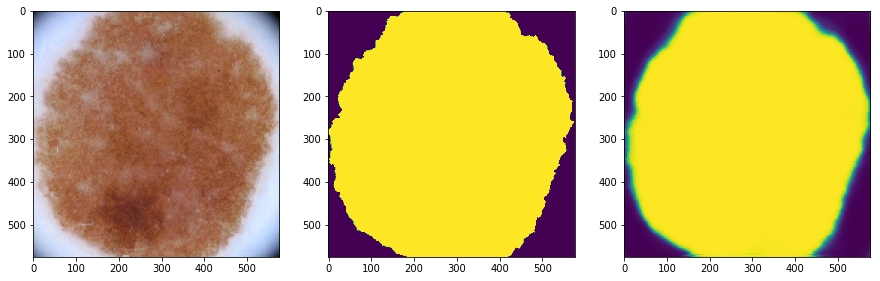

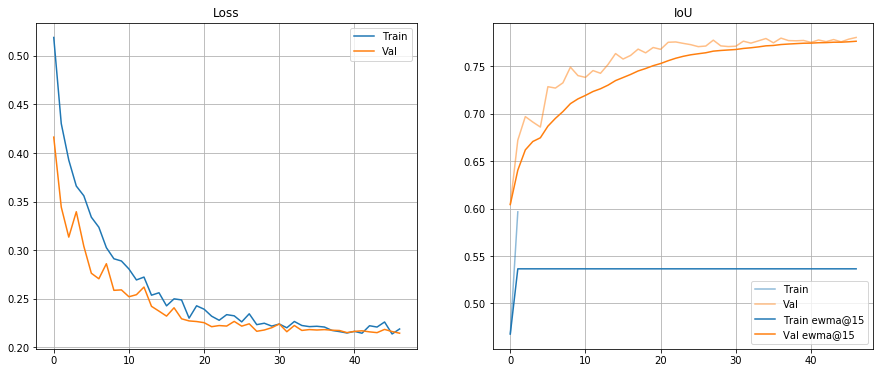

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 91%|█████████ | 588/648 [00:40<00:04, 14.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
fold = 0
model = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='dpn92_checkpoints', 
    prefix='_shrinked',
    lr=5e-5,
    aug_strength=1.,
    verbose=True,
    train_batch_size=14,
    nums=None,
    hard_negative_miner=HardNegativeMiner(rate=10),
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

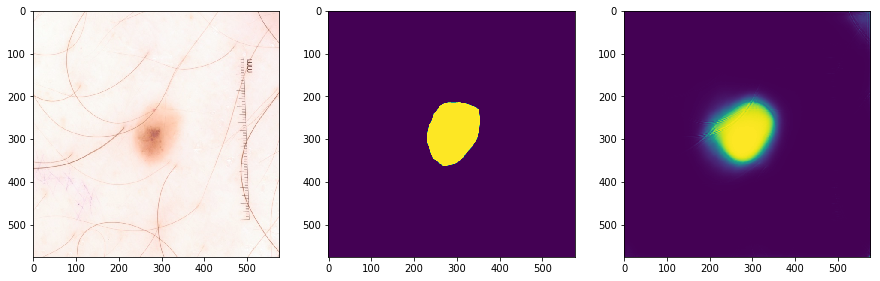

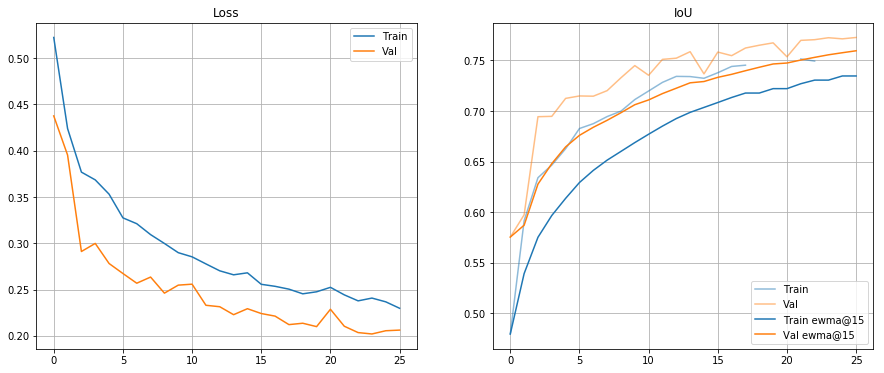

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 70%|███████   | 456/648 [00:31<00:13, 14.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
fold = 1
model = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='dpn92_checkpoints', 
    prefix='_shrinked',
    lr=5e-5,
    aug_strength=1.,
    verbose=True,
    train_batch_size=14,
    nums=None,
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

In [ ]:
fold = 2
model = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='dpn92_checkpoints', 
    prefix='_shrinked',
    lr=5e-5,
    aug_strength=1.,
    verbose=True,
    train_batch_size=14,
    nums=None,
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

In [ ]:
fold = 3
model = orchestrate(
    data_dir=PATHS['DATA'],
    fold=fold,
    epoch_nb=EPOCHS_NB,
    checkpoints_pth='dpn92_checkpoints', 
    prefix='_shrinked',
    lr=5e-5,
    aug_strength=1.,
    verbose=True,
    train_batch_size=14,
    nums=None,
    lr_scheduler=optim.lr_scheduler.ExponentialLR,
    devices=[0, 1]
)

In [ ]:
models = list()
fold = 0
epoch_i = 99

for i in tqdm(range(0, 5)):
    models.append(
        torch.load(
            os.path.join('checkpoints', 'extra_checkpoint_{}.fold_{}'.format(i, fold)), 
        )
    )


In [36]:
fold = 2

model = torch.load(
    os.path.join('dpn_checkpoints', 'fold_{}_checkpoint.epoch_{}'.format(fold, 10 * (EPOCHS_NB // 10) - 1)), 
)

train_dataset, val_dataset = get_datasets(PATHS['DATA'], fold, '_shrinked')
_, val_datagen = get_datagens(train_dataset, val_dataset)
loss = LossBinary(jaccard_weight=.3)
l, iou, losses, ious = validate(model, loss, val_datagen)

100%|██████████| 648/648 [00:42<00:00, 15.39it/s]


In [113]:
mean=[0.53659743, 0.58239675, 0.708252]
std=[0.12663189, 0.11222798, 0.09813331]

n = 6
x = val_dataset[n][0][None, ...]

In [114]:
labels = model(x)

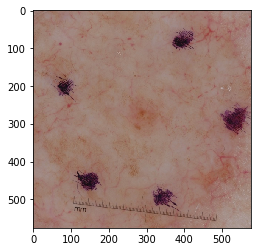

In [115]:
plt.imshow((np.rollaxis(val_dataset[n][0].data.cpu().numpy(), 0, 3) * std + mean)[..., ::-1])

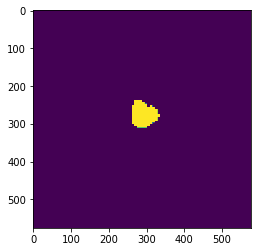

In [116]:
plt.imshow(np.squeeze(val_dataset[n][1].data.cpu().numpy()))

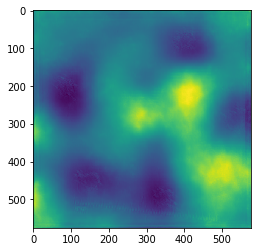

In [117]:
plt.imshow(np.squeeze(labels.data.cpu()))

In [107]:
np.where(np.array(ious) < .6)

(array([  1,   6,  10,  12,  19,  21,  29,  30,  33,  34,  42,  45,  48,
         52,  53,  55,  58,  63,  65,  69,  85,  88,  89,  93,  96, 101,
        104, 107, 110, 112, 116, 128, 145, 148, 150, 154, 156, 158, 159,
        160, 164, 175, 185, 186, 191, 194, 196, 197, 198, 202, 206, 208,
        218, 225, 227, 230, 237, 239, 240, 243, 249, 250, 259, 284, 289,
        299, 302, 310, 311, 314, 315, 329, 332, 336, 337, 344, 352, 363,
        369, 373, 375, 377, 381, 398, 410, 417, 419, 428, 439, 447, 454,
        463, 468, 471, 481, 486, 494, 496, 499, 506, 507, 510, 518, 520,
        522, 529, 534, 537, 538, 557, 560, 573, 577, 582, 586, 592, 599,
        617, 618, 623, 625, 627, 631, 632, 643]),)

In [39]:
iou

0.681229548782568

In [37]:
l, iou, losses, ious

(0.2124237956042275,
 0.681229548782568,
 [array(0.2247939, dtype=float32),
  array(0.5588324, dtype=float32),
  array(0.05729372, dtype=float32),
  array(0.06939168, dtype=float32),
  array(0.64713067, dtype=float32),
  array(0.13530195, dtype=float32),
  array(0.37169296, dtype=float32),
  array(0.14066118, dtype=float32),
  array(0.047045, dtype=float32),
  array(0.06705855, dtype=float32),
  array(0.3325485, dtype=float32),
  array(0.05948873, dtype=float32),
  array(0.58627456, dtype=float32),
  array(0.09358928, dtype=float32),
  array(0.16318753, dtype=float32),
  array(0.07983707, dtype=float32),
  array(0.15122402, dtype=float32),
  array(0.20696653, dtype=float32),
  array(0.06337848, dtype=float32),
  array(0.9143177, dtype=float32),
  array(0.18734823, dtype=float32),
  array(0.34956717, dtype=float32),
  array(0.39067948, dtype=float32),
  array(0.09932913, dtype=float32),
  array(0.14156778, dtype=float32),
  array(0.12524384, dtype=float32),
  array(0.20621894, dtype=flo

In [19]:
l, iou = ansamble(models, loss, val_datagen)

  0%|          | 0/648 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 648/648 [02:33<00:00,  4.22it/s]


In [21]:
l, iou

(0.11326487270402319, 0.8901663427641814)

[0.8833063990146853,
 0.8753035463174015,
 0.8773371242727841,
 0.8841517122801968,
 0.8804444854977357]

In [23]:
model_ = models[0]
sd_ = model_.state_dict()

for model in tqdm(models[1:]):
    sd = model.state_dict()
    for key in sd.keys():
        sd_[key] += sd[key]

for key in sd.keys():
    sd_[key] /= 5.

100%|██████████| 4/4 [00:00<00:00, 124.23it/s]


In [25]:
l, iou = validate(model, loss, val_datagen)

  0%|          | 0/648 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 648/648 [00:41<00:00, 15.55it/s]


In [26]:
l, iou

(0.12752374013264975, 0.8804444854977357)